In [1]:
from dataset import StockDataset, normalize_stock
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from StockPredictorLSTM import StockPredictorLSTM, normalize
from util.LSTM import LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from dataset import StockDataset
from datetime import timedelta
from tqdm.auto import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim

In [236]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [237]:
import os
import glob

In [238]:
# set style of graphs
plt.style.use('ggplot')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [3]:
df = pd.read_csv('../../stock/SAN-MC.csv', parse_dates=True, index_col='Date').dropna(how="any")
X_train, X_test = train_test_split(df, test_size=0.02, shuffle=False)

In [4]:
predictor = StockPredictorLSTM(hidden_size=32, num_layers=1, pretrained=False)
predictor.fit(X_train, batch_size=16, epochs=10, sequence_length=60)

LSTM(
  (lstm): LSTM(4, 32, batch_first=True)
  (fc_1): Linear(in_features=32, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
y_pred = predictor.predict(X_test)

In [294]:
def generate_trajectory(dataframe, n_feature):
    df = dataframe.copy
    Open = dataframe['Open'][-1]
    High = dataframe['High'][-1]
    Low = dataframe['Low'][-1]
    Close = dataframe['Close'][-1]
    Volume = dataframe['Volume'][-1]

    B = np.array([Open, High, Low, Close, Volume])

    walk = np.zeros((0,5))
    walk = np.vstack([walk, B])
    
    for i in range(1, n_feature):
        for j in range(0, len(B)):
            s_i = np.random.normal(0, 1)  
            B[j] = walk[i-1][j] + s_i*np.sqrt(1/n_feature)
        
        walk = np.vstack([walk, B])

    return pd.DataFrame(walk, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

In [295]:
data = generate_trajectory(X_train, 60)

In [296]:
n_feature = len(X_test)

In [312]:
def processing(n_steps, n_feature):
    pred = np.zeros((0, n_feature))
    for epoch in tqdm(range(0,n_steps)):
        test = generate_trajectory(X_train[-n_feature:], n_feature)
        y_pred = predictor.predict(test, plot=False)
        pred = np.vstack([pred, y_pred.reshape(-1)])

    return pred

pred = processing(n_steps=4, n_feature=n_feature)

  0%|          | 0/4 [00:00<?, ?it/s]

In [313]:
#for i in range(pred.shape[0]):
#    for j in range(pred.shape[1]):
y_pred = np.array([])
for i in range(pred.shape[1]):
    y_pred = np.append(y_pred, pred[:, [i]].mean())

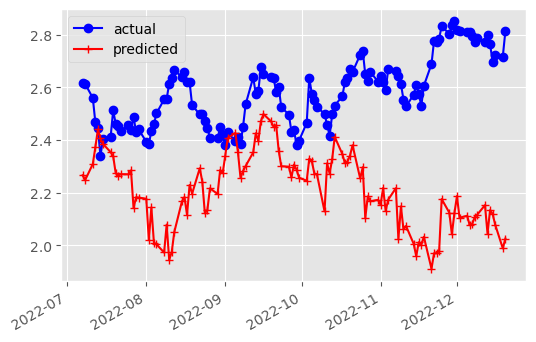

In [314]:
y_test = (X_test['Close']).values 
days = np.array(X_test.index, dtype="datetime64[ms]")
            
fig = plt.figure()
            
axes = fig.add_subplot(111)
axes.plot(days, y_test, 'bo-', label="actual") 
axes.plot(days, y_pred, 'r+-', label="predicted")
            
fig.autofmt_xdate()
            
plt.legend()
plt.show()